# Shallow Water Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import animation
from IPython.display import HTML

## Newtonian, 2d, single layer

In [462]:
# define grids
nx = 2000
nt = 2000
xmin = 0.
xmax = 10.

x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
hu = np.zeros((nx, nt+1))
h = np.zeros((nx, nt+1))
# Start off with an initial water hill
h[1:-1,0] = 1 + 0.4 * np.exp(-(x-5)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h[0,0] = h[-2,0]
h[-1,0] = h[1,0]

#hu[:,0] = 0.1 * h[:,0]

dx = x[1] - x[0]
dt = 0.5 * dx

# set gravity
g = 1.0

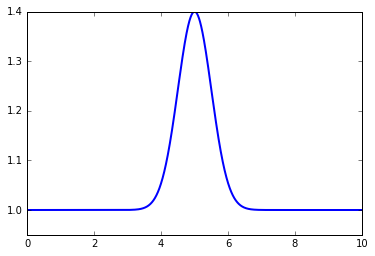

In [463]:
plt.plot(x,h[1:-1,0], lw=2)
plt.show()

In [464]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    # Jacobean
    J = np.zeros((nx-2, 2, 2))
    J[:,0,1] = 1.
    J[:,1,0] = -(hu[1:-1,n]/h[1:-1,n])**2 + g * h[1:-1,n]
    J[:,1,1] =  2 * hu[1:-1,n] / h[1:-1,n]
    
    J2 = np.array([np.dot(J[i,:,:], J[i,:,:]) for i in range(nx-2)])
    
    h[1:-1,n+1] = h[1:-1,n] - 0.5 * dt/dx * (J[:,0,0] * (h[2:,n] - h[:-2,n]) + J[:,0,1] * (hu[2:,n] - hu[:-2,n])) +\
                  0.5 * (dt/dx)**2 * (J2[:,0,0] * (h[:-2,n] - 2 * h[1:-1,n] + h[2:,n]) + \
                                      J2[:,0,1] * (hu[:-2,n] - 2 * hu[1:-1,n] + hu[2:,n]))
    hu[1:-1,n+1] = hu[1:-1,n] - 0.5 * dt/dx * (J[:,1,0] * (h[2:,n] - h[:-2,n]) + J[:,1,1] * (hu[2:,n] - hu[:-2,n]))+ \
                  0.5 * (dt/dx)**2 * (J2[:,1,0] * (h[:-2,n] - 2 * h[1:-1,n] + h[2:,n]) + \
                                      J2[:,1,1] * (hu[:-2,n] - 2 * hu[1:-1,n] + hu[2:,n]))

    # do boundaries - periodic
    h[0,n+1] = h[-2,n+1]
    h[-1,n+1] = h[1,n+1]
    hu[0,n+1] = hu[-2,n+1]
    hu[-1,n+1] = hu[1,n+1]

In [465]:
for i in range(nt):
    evolve(i)

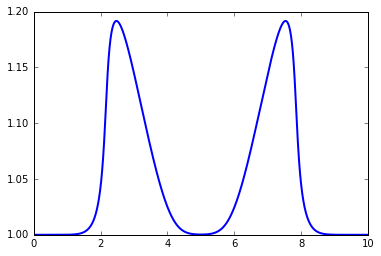

In [466]:
plt.plot(x,h[1:-1,800], lw=2)
plt.show()

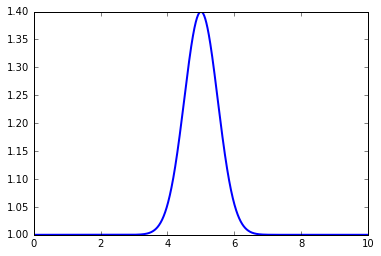

In [333]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(1.,1.4))
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(x, h[1:-1,i*10])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=130, interval=25)#, blit=True)

In [334]:
HTML(anim.to_html5_video())

## Newtonian, 2d, multilayer, no heat transfer

In [451]:
# define grids
nx = 2000
nt = 2000
nlayers = 2
xmin = 0.
xmax = 10.

x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
rho = np.ones(nlayers)
hu = np.zeros((nlayers, nx, nt+1))
h = np.zeros((nlayers, nx, nt+1))
# Start off with an initial water hill
h[0,1:-1,0] = 1 + 0.4 * np.exp(-(x-2)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h[1,1:-1,0] = 0.8 + 0.2 * np.exp(-(x-7)**2*2)
h[:,0,0] = h[:,-2,0]
h[:,-1,0] = h[:,1,0]

#hu[:,0] = 0.1 * h[:,0]

# going to try setting the top fluid to be heavier 
rho[0] = 3

dx = x[1] - x[0]
dt = 0.5 * dx

# set gravity
g = 1.0

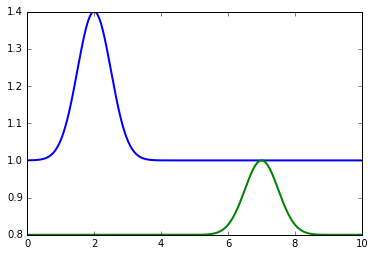

In [460]:
plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

In [453]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    for j in range(nlayers):

        # Jacobian
        J = np.zeros((nx-2, 2, 2))
        J[:,0,1] = 1.
        J[:,1,0] = -(hu[j,1:-1,n]/h[j,1:-1,n])**2 + g * h[j,1:-1,n]
        J[:,1,1] =  2 * hu[j,1:-1,n] / h[j,1:-1,n]

        J2 = np.array([np.dot(J[i,:,:], J[i,:,:]) for i in range(nx-2)])
        
        # calculate source term
        sum_hs = np.zeros(nx)
        for i in range(j):
            sum_hs += rho[i] / rho[j] * h[i,:,n]
        for i in range(j+1,nlayers):
            sum_hs += h[i,:,n]
        dx_sumhs = 0.5/dx * (sum_hs[2:] - sum_hs[:-2])# - 0.5/dx**2 * (sum_hs[2:] - 2 * sum_hs[1:-1] + sum_hs[:-2])
        
        beta = g * dx_sumhs

        h[j,1:-1,n+1] = h[j,1:-1,n] - 0.5 * dt/dx * (J[:,0,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                     J[:,0,1] * (hu[j,2:,n] - hu[j,:-2,n])) +\
                      0.5 * (dt/dx)**2 * (J2[:,0,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,0,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n]))
        hu[j,1:-1,n+1] = (1 - dt * beta + 0.5 * dt**2 * beta**2) * hu[j,1:-1,n] - \
                        0.5 * dt/dx * (1 - dt*beta) * (J[:,1,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                       J[:,1,1] * (hu[j,2:,n] - hu[j,:-2,n]))+ \
                      0.5 * (dt/dx)**2 * (J2[:,1,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,1,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n]))

    # do boundaries - periodic
    h[:,0,n+1] = h[:,-2,n+1]
    h[:,-1,n+1] = h[:,1,n+1]
    hu[:,0,n+1] = hu[:,-2,n+1]
    hu[:,-1,n+1] = hu[:,1,n+1]

In [454]:
for i in range(nt):
    evolve(i)

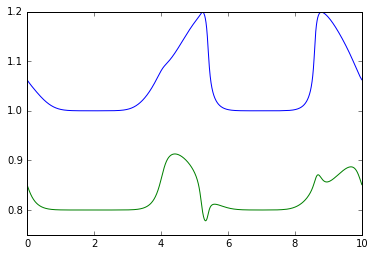

In [455]:
plt.plot(x,h[0,1:-1,1000],x,h[1,1:-1,1000], lw=2)
plt.show()

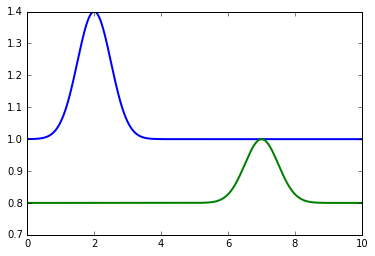

In [456]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(0.7,1.4))
line = ax.plot([],[], lw=2)[0]
line2 = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(x, h[0,1:-1,i*10])
    line2.set_data(x, h[1,1:-1,i*10])

anim = animation.FuncAnimation(fig, animate, frames=130, interval=25)#, init_func=init)

In [457]:
HTML(anim.to_html5_video())

## Newtonian, 2d, multilayer, heat transfer

In [509]:
# define grids
nx = 2000
nt = 2000
nlayers = 2
xmin = 0.
xmax = 10.

x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
rho = np.ones(nlayers)
hu = np.zeros((nlayers, nx, nt+1))
h = np.zeros((nlayers, nx, nt+1))
# Start off with an initial water hill
h[0,1:-1,0] = 1 + 0.4 * np.exp(-(x-2)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h[1,1:-1,0] = 0.8 + 0.2 * np.exp(-(x-7)**2*2)
h[:,0,0] = h[:,-2,0]
h[:,-1,0] = h[:,1,0]

#hu[:,0] = 0.1 * h[:,0]

# going to try setting the top fluid to be heavier 
rho[0] = 3

dx = x[1] - x[0]
dt = 0.5 * dx

# set gravity
g = 1.0

# heating rate - flux of material from lower to upper layer. Set Q of top layer as 0.
Q = np.zeros(nlayers)
Q[1] = 0.05

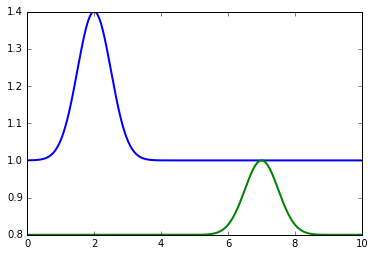

In [500]:
plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

In [513]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    for j in range(nlayers):

        # Jacobean
        J = np.zeros((nx-2, 2, 2))
        J[:,0,1] = 1.
        J[:,1,0] = -(hu[j,1:-1,n]/h[j,1:-1,n])**2 + g * h[j,1:-1,n]
        J[:,1,1] =  2 * hu[j,1:-1,n] / h[j,1:-1,n]

        J2 = np.array([np.dot(J[i,:,:], J[i,:,:]) for i in range(nx-2)])
        
        # calculate source terms
        sum_hs = np.zeros(nx)
        sum_qs = 0
        
        if j < (nlayers - 1): # i.e. it has another layer beneath it
            sum_qs += -rho[j+1]/rho[j] * abs((Q[j+1] - Q[j]))
            deltaQv = rho[j+1]/rho[j] * max(0,Q[j] - Q[j+1]) * (hu[j,:,n] - hu[j+1,:,n]) / h[j,:,n]
        if j > 0: # i.e. has another layer above it
            sum_qs +=  abs(Q[j] - Q[j-1])
            deltaQv = max(0, Q[j] - Q[j-1]) * (hu[j,:,n] - hu[j-1,:,n]) / h[j,:,n]
        
        for i in range(j):
            sum_hs += rho[i] / rho[j] * h[i,:,n]
        for i in range(j+1,nlayers):
            sum_hs += h[i,:,n]
        dx_sumhs = 0.5/dx * (sum_hs[2:] - sum_hs[:-2])# - 0.5/dx**2 * (sum_hs[2:] - 2 * sum_hs[1:-1] + sum_hs[:-2])
        
        beta = g * dx_sumhs

        h[j,1:-1,n+1] = h[j,1:-1,n] - 0.5 * dt/dx * (J[:,0,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                     J[:,0,1] * (hu[j,2:,n] - hu[j,:-2,n])) +\
                      0.5 * (dt/dx)**2 * (J2[:,0,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,0,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n])) +\
                      dt * sum_qs
        hu[j,1:-1,n+1] = (1 - dt * beta + 0.5 * dt**2 * beta**2) * hu[j,1:-1,n] - \
                        0.5 * dt/dx * (1 - dt*beta) * (J[:,1,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                       J[:,1,1] * (hu[j,2:,n] - hu[j,:-2,n]))+ \
                      0.5 * (dt/dx)**2 * (J2[:,1,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,1,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n])) -\
                      dt * deltaQv[1:-1]

    # do boundaries - periodic
    h[:,0,n+1] = h[:,-2,n+1]
    h[:,-1,n+1] = h[:,1,n+1]
    hu[:,0,n+1] = hu[:,-2,n+1]
    hu[:,-1,n+1] = hu[:,1,n+1]

In [514]:
for i in range(nt):
    evolve(i)

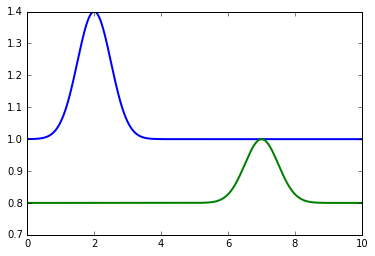

In [515]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(0.7,1.4))
line = ax.plot([],[], lw=2)[0]
line2 = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(x, h[0,1:-1,i*10])
    line2.set_data(x, h[1,1:-1,i*10])

anim = animation.FuncAnimation(fig, animate, frames=130, interval=25)#, init_func=init)

In [516]:
HTML(anim.to_html5_video())

## Newtonian, 3d

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [102]:
# define grids
nx = 100
ny = 100
nt = 50
nlayers = 2
xmin = 0.
xmax = 10.
ymin = 0.
ymax = 10.

rho = np.ones(nlayers)
# going to try setting the top fluid to be heavier 
rho[0] = 1.5

# set gravity
g = 1.0

# heating rate - flux of material from lower to upper layer. Set Q of top layer as 0.
Q = np.zeros(nlayers)
#Q[1] = 0.05

# Coriolis parameter - two times the angular frequency
f = 0.1

class U:
    def __init__(self, nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, g, Q, f, periodic=True):
        self.nlayers = nlayers
        self.nx = nx
        self.ny = ny
        self.nt = nt
        
        self.U = np.zeros((3, nlayers, nx, ny, nt+1))
        
        self.x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
        self.y = np.linspace(ymin, ymax, num=ny-2, endpoint=False)
        self.rho = rho
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = 0.5 * min(self.dx, self.dy)
        
        self.g = g
        self.Q = Q
        self.f = f
        self.periodic = periodic
        
    def h(self,indices):
        return self.U[(0,) + tuple(indices)]
    
    def hu(self,indices):
        return self.U[(1,) + tuple(indices)]

    def hv(self,indices):
        return self.U[(2,) + tuple(indices)]
        
    def initial_data(self, h0=None, hu0=None, hv0=None):
        """
        Set the initial data
        """
        
        if h0 is not None:
            self.U[0,:,:,:,0] = h0
            
        if hu0 is not None:
            self.U[1,:,:,:,0] = hu0
            
        if hv0 is not None:
            self.U[2,:,:,:,0] = hv0
            
        # enforce bcs
        self.bcs(0)
        
    def Uj(self, layer, t):
        return self.U[:,layer,:,:,t]
    
    def bcs(self, t):
        
        if self.periodic:
            self.U[:,:,0,:,t] = self.U[:,:,-2,:,t]
            self.U[:,:,:,0,t] = self.U[:,:,:,-2,t]
            self.U[:,:,-1,:,t] = self.U[:,:,1,:,t]
            self.U[:,:,:,-1,t] = self.U[:,:,:,1,t]
            
        else: #outflow
            self.U[:,:,0,:,t] = self.U[:,:,1,:,t]
            self.U[:,:,:,0,t] = self.U[:,:,:,1,t]
            self.U[:,:,-1,:,t] = self.U[:,:,-2,:,t]
            self.U[:,:,:,-1,t] = self.U[:,:,:,-2,t]

    
U = U(nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, g, Q, f, periodic=False)
#q = np.zeros((nlayers, 3, nx, ny, nt+1))
#hu = np.zeros((nlayers, nx, ny, nt+1))
#h = np.zeros((nlayers, nx, ny, nt+1))
# Start off with an initial water hill
h0 = np.zeros_like(U.U[0,:,:,:,0])
h0[0,1:-1,1:-1] = 1 + 0.4 * np.exp(-((U.x[:,np.newaxis]-2)**2 + (U.y[np.newaxis,:]-2)**2)*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h0[1,1:-1,1:-1] = 0.8 + 0.2 * np.exp(-((U.x[:,np.newaxis]-7)**2 + (U.y[np.newaxis,:]-7)**2)*2)
#hu[:,0] = 0.1 * h[:,0]

# set coriolis source to be outside of grid, beyond bottom left corner
hu0 = np.zeros_like(U.U[1,:,:,:,0])
hu0[:,1:-1,1:-1] = -0.5 * f * (U.x[np.newaxis,:,np.newaxis]+1) 
hu0[np.isnan(hu0)] = 0
hu0 *= h0
    
hv0 = np.zeros_like(U.U[2,:,:,:,0])
hv0[:,1:-1,1:-1] = 0.5 * f * (U.y[np.newaxis,np.newaxis,:]+1) 
hv0[np.isnan(hv0)] = 0
hv0 *= h0

U.initial_data(h0=h0, hu0=hu0, hv0=hv0)

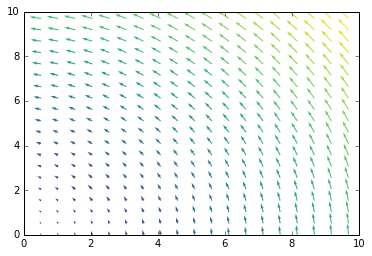

In [103]:
# print initial velocity field
X, Y = np.meshgrid(U.x,U.y)
magv = np.sqrt(U.U[1,0,1:-1:5,1:-1:5,0]**2 + U.U[2,0,1:-1:5,1:-1:5,0]**2) / U.U[0,0,1:-1:5,1:-1:5,0]
#print(magv)
plot = plt.figure()
plt.quiver(X[::5,::5], Y[::5,::5], U.U[1,0,1:-1:5,1:-1:5,0], U.U[2,0,1:-1:5,1:-1:5,0], magv, cmap=cm.viridis)
plt.show()

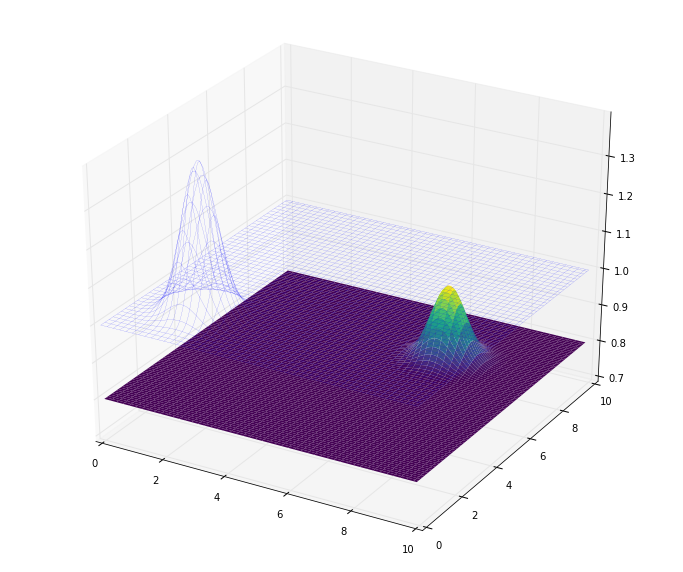

In [107]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0.7,1.4)

ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

In [75]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    for j in range(nlayers):

        # Jacobians
        def Jx(x,y):
            h = U.U[0,j, x, y, n]
            u = U.U[1,j, x, y, n] / U.U[0,j, x, y, n]
            v = U.U[2,j, x, y, n] / U.U[0,j, x, y, n]
            return np.array([[0, 1, 0], [-u**2 + U.g * h, 2*u, 0], [-u * v, v, u]]).T
        
        def Jy(x,y):
            h = U.U[0,j, x, y, n]
            u = U.U[1,j, x, y, n] / U.U[0,j, x, y, n]
            v = U.U[2,j, x, y, n] / U.U[0,j, x, y, n]
            return np.array([[0, 0, 1], [-u*v, v, u], [-v**2 + U.g*h, 0, 2*v]]).T
        
        A = np.array([[Jx(i,k) for k in range(1,U.ny-1)] for i in range(1,U.nx-1)])
        B = np.array([[Jy(i,k) for k in range(1,U.ny-1)] for i in range(1,U.nx-1)])
        
        A2 = np.array([[np.dot(A[i,k,:,:], A[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])
        B2 = np.array([[np.dot(B[i,k,:,:], B[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])
        AB = np.array([[np.dot(A[i,k,:,:], B[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])        
        
        # to simplify indexing to 3 indices rather than 5
        qn = U.U[:,j,:,:,n]
        
        U.U[:,j,1:-1,1:-1,n+1] = qn[:,1:-1,1:-1] - \
            0.5 * U.dt/U.dx * np.einsum('ijkl,lij->kij', A[:,:,:,:], (qn[:,2:,1:-1] - qn[:,:-2,1:-1])) -\
            0.5 * U.dt/U.dy * np.einsum('ijkl,lij->kij', B[:,:,:,:], (qn[:,1:-1,2:] - qn[:,1:-1,:-2])) +\
            0.5 * (U.dt/U.dx)**2 * np.einsum('ijkl,lij->kij', A2[:,:,:,:], (qn[:,2:,1:-1] - 2*qn[:,1:-1,1:-1] + qn[:,:-2,1:-1])) +\
            0.5 * (U.dt/U.dy)**2 * np.einsum('ijkl,lij->kij', B2[:,:,:,:], (qn[:,1:-1,2:] - 2*qn[:,1:-1,1:-1] + qn[:,1:-1,:-2])) -\
            0.25 * U.dt**2/(U.dx*U.dy) * np.einsum('ijkl,lij->kij', AB[:,:,:,:], (qn[:,2:,2:] - qn[:,2:,:-2] -\
                                                                      qn[:,:-2,2:] + qn[:,:-2,:-2])) 
            
    # do boundaries - periodic
    U.bcs(n+1)   
    U_half = U.U[:,:,:,:,n+1]
    
    for j in range(nlayers):
        
            
        # calculate source terms
        # a more sophisticated scheme for the source terms is needed, but that's a real headache so shall ignore for now
        # and just use operator splitting
        h = U_half[0,:,:,:]
        hu = U_half[1,:,:,:]
        hv = U_half[2,:,:,:] 
        
        sum_hs = np.zeros((U.nx,U.ny))
        sum_qs = 0
        
        if j < (nlayers - 1): # i.e. it has another layer beneath it
            sum_qs += -U.rho[j+1]/U.rho[j] * abs((U.Q[j+1] - U.Q[j]))
            deltaQu = U.rho[j+1]/U.rho[j] * max(0,U.Q[j] - U.Q[j+1]) * (hu[j,:,:] - hu[j+1,:,:]) / h[j,:,:]
            deltaQv = U.rho[j+1]/U.rho[j] * max(0,U.Q[j] - U.Q[j+1]) * (hv[j,:,:] - hv[j+1,:,:]) / h[j,:,:]
        if j > 0: # i.e. has another layer above it
            sum_qs +=  abs(U.Q[j] - U.Q[j-1])
            deltaQu = max(0, U.Q[j] - U.Q[j-1]) * (hu[j,:,:] - hu[j-1,:,:]) / h[j,:,:]
            deltaQv = max(0, U.Q[j] - U.Q[j-1]) * (hv[j,:,:] - hv[j-1,:,:]) / h[j,:,:]
        
        for i in range(j):
            sum_hs += U.rho[i] / U.rho[j] * h[i,:,:]
        for i in range(j+1,nlayers):
            sum_hs += h[i,:,:]
        dx_sumhs = 0.5/U.dx * (sum_hs[2:,1:-1] - sum_hs[:-2,1:-1])
        dy_sumhs = 0.5/U.dy * (sum_hs[1:-1,2:] - sum_hs[1:-1,:-2])
        
        # h
        U.U[0,j,1:-1,1:-1,n+1] += U.dt * (sum_qs)
        
        # hu
        U.U[1,j,1:-1,1:-1,n+1] += U.dt * (-deltaQu[1:-1,1:-1] - U.g * dx_sumhs) * h[j,1:-1,1:-1] + \
            U.dt * U.f * hv[j,1:-1,1:-1]
        
        # hv
        U.U[2,j,1:-1,1:-1,n+1] += U.dt * (-deltaQv[1:-1,1:-1] - U.g * dy_sumhs) * h[j,1:-1,1:-1] - \
            U.dt * U.f * hu[j,1:-1,1:-1]
        
    # do boundaries - periodic
    U.bcs(n+1)

In [108]:
for i in range(nt):
    evolve(i)

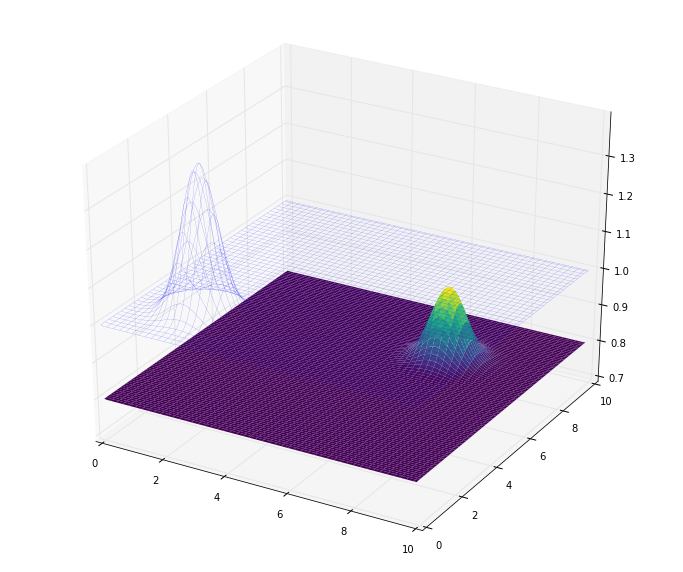

In [109]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0.7,1.4)

n = 1

ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,n], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,n], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

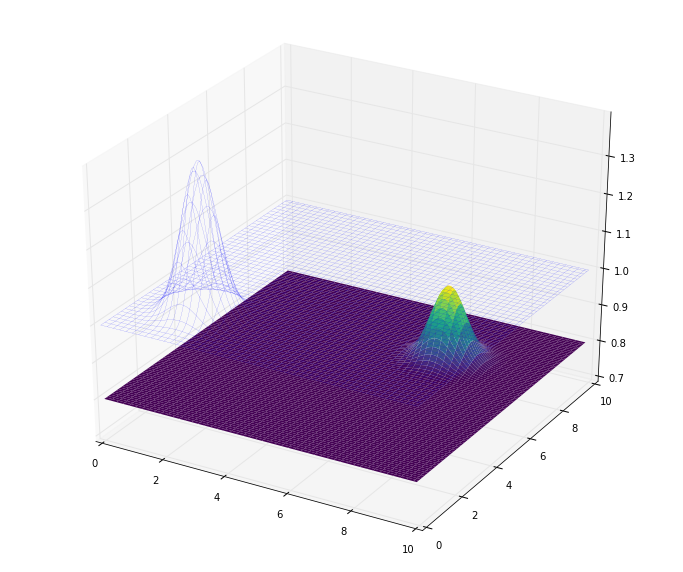

In [110]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
#ax = plt.axes(xlim=(0,10), zlim=(0.7,1.4))
#surface_1 = ax.plot_surface([],[],[], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)[0]

#surface_2 = ax.plot_wireframe([],[],[], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)[0]
#line = ax.plot([],[], lw=2)[0]
#line2 = ax.plot([],[], lw=2)[0]

surface_1 = ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
surface_2 = ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

def init():
    surface_1 = ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    surface_2 = ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)


def animate(i):
    ax.clear()
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,i], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,i], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=30, interval=200)#, init_func=init)

In [111]:
HTML(anim.to_html5_video())

## GR, 2d

In [101]:
# define grids
nx = 2000
nt = 1000
nlayers = 2
# moved boundaries away as there was some nasty feedback occuring here
xmin = -5.
xmax = 15.
alpha = 0.9
beta = 0.
gamma = 1 / alpha**2

class U:
    def __init__(self, nlayers, nx, nt, xmin, xmax, rho, alpha, beta, gamma, periodic=True):
        self.nlayers = nlayers
        self.nx = nx
        self.nt = nt
        
        self.U = np.zeros((2, nlayers, nx, nt+1))
        
        self.x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
        self.rho = rho
        
        self.dx = self.x[1] - self.x[0]
        self.dt = 0.1 * self.dx
        
        # metric stuff
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma # gamma down
        self.gamma_up = 1/gamma
        
        self.periodic = periodic
        
    def D(self,indices):
        return self.U[(0,) + tuple(indices)]
    
    def Sx(self,indices):
        return self.U[(1,) + tuple(indices)]
        
    def initial_data(self, D0=None, Sx0=None):
        """
        Set the initial data
        """
        
        if D0 is not None:
            self.U[0,:,:,0] = D0
            
        if Sx0 is not None:
            self.U[1,:,:,0] = Sx0
            
        # enforce bcs
        self.bcs(0)
        
    def Uj(self, layer, t):
        return self.U[:,layer,:,t]
    
    def bcs(self, t):
        
        if self.periodic:
            self.U[:,:,0,t] = self.U[:,:,-2,t]
            self.U[:,:,-1,t] = self.U[:,:,1,t]
        
        else: # outflow
            self.U[:,:,0,t] = self.U[:,:,1,t]
            self.U[:,:,-1,t] = self.U[:,:,-2,t]

rho = np.ones(nlayers)

U = U(nlayers, nx, nt, xmin, xmax, rho, alpha, beta, gamma, periodic=False)

# Start off with an initial water hill
D0 = np.zeros_like(U.U[0,:,:,0])
D0[0,1:-1] = 1 + 0.2 * np.exp(-(U.x-2)**2*2) 
D0[1,1:-1] = 0.8 + 0.1 * np.exp(-(U.x-7)**2*2)

U.initial_data(D0=D0)

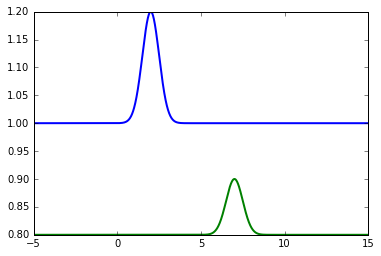

In [102]:
plt.plot(U.x,U.U[0,0,1:-1,0],U.x,U.U[0,1,1:-1,0], lw=2)
plt.show()

In [103]:
def evolve(n):
    
    for j in range(nlayers):

        # Jacobians
        def Jx(x):
            # do naive c2p for now
            W = np.sqrt(U.U[1, j, x, n] * U.U[1, j, x, n] * U.gamma_up / U.U[0, j, x, n]**2 + 1)
            ph = U.U[0, j, x, n] / W # 
            u = U.U[1, j, x, n] / (U.U[0, j, x, n] * W) # u_down
            
            qx = u * U.gamma_up - U.beta/U.alpha
            
            xi = 1 / (1 + u**2 * W**2)
            
            return np.array([[qx - u*xi, xi * (qx*u*(W**2-W) +1)], [1/W, qx]]).T
        
        
        A = np.array([Jx(i) for i in range(1,U.nx-1)])
        
        A2 = np.array([np.dot(A[i,:], A[i,:]) for i in range(U.nx-2)])       
        
        # to simplify indexing to 2 indices rather than 4
        qn = U.U[:,j,:,n]
        
        U.U[:,j,1:-1,n+1] = qn[:,1:-1] - \
            0.5 * U.dt/U.dx * np.einsum('ikl,li->ki', A[:,:,:], (qn[:,2:] - qn[:,:-2])) -\
            0.5 * (U.dt/U.dx)**2 * np.einsum('ikl,li->ki', A2[:,:,:], (qn[:,2:] - 2*qn[:,1:-1] + qn[:,:-2]))
            
    # do boundaries - periodic
    U.bcs(n+1)   
    
    """
    Going to not include any source terms for now
    U_half = U.U[:,:,:,n+1]
    
    
    for j in range(nlayers):
        
            
        # calculate source terms
        # a more sophisticated scheme for the source terms is needed, but that's a real headache so shall ignore for now
        # and just use operator splitting
        h = U_half[0,:,:]
        hu = U_half[1,:,:]
        hv = U_half[2,:,:] 
        
        sum_hs = np.zeros(U.nx)
        sum_qs = 0
        
        if j < (nlayers - 1): # i.e. it has another layer beneath it
            sum_qs += -U.rho[j+1]/U.rho[j] * abs((U.Q[j+1] - U.Q[j]))
            deltaQu = U.rho[j+1]/U.rho[j] * max(0,U.Q[j] - U.Q[j+1]) * (hu[j,:] - hu[j+1,:]) / h[j,:]
        if j > 0: # i.e. has another layer above it
            sum_qs +=  abs(U.Q[j] - U.Q[j-1])
            deltaQu = max(0, U.Q[j] - U.Q[j-1]) * (hu[j,:] - hu[j-1,:]) / h[j,:]
        
        for i in range(j):
            sum_hs += U.rho[i] / U.rho[j] * h[i,:]
        for i in range(j+1,nlayers):
            sum_hs += h[i,:,:]
        dx_sumhs = 0.5/U.dx * (sum_hs[2:] - sum_hs[:-2])
        
        # h
        U.U[0,j,1:-1,n+1] += U.dt * (sum_qs)
        
        # hu
        U.U[1,j,1:-1,n+1] += U.dt * (-deltaQu[1:-1] - U.g * dx_sumhs) * h[j,1:-1]
        
        
    # do boundaries - periodic
    U.bcs(n+1)
    """

In [104]:
for i in range(nt):
    evolve(i)

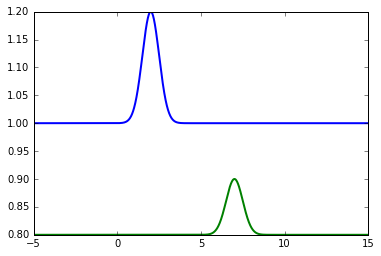

In [105]:
plt.plot(U.x,U.U[0, 0, 1:-1, 0],U.x,U.U[0, 1, 1:-1, 0], lw=2)
plt.show()

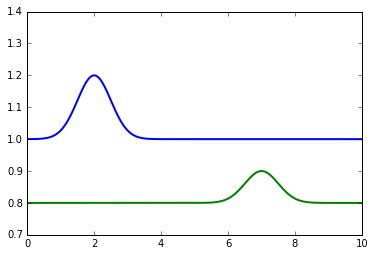

In [106]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(0.7,1.4))
line = ax.plot([],[], lw=2)[0]
line2 = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(U.x, U.U[0, 0, 1:-1,i*10])
    line2.set_data(U.x, U.U[0, 1, 1:-1,i*10])

anim = animation.FuncAnimation(fig, animate, frames=100, interval=60)#, init_func=init)

In [107]:
HTML(anim.to_html5_video())

## GR 3d

In [85]:
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [108]:
# define grids
nx = 100
ny = 100
nt = 100
nlayers = 2
xmin = -5.
xmax = 15.
ymin = -5.
ymax = 15.
alpha = 0.9
beta = [0., 0.]
gamma = 1 / alpha**2 * np.eye(2)

class U:
    def __init__(self, nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, alpha, beta, gamma, periodic=True):
        self.nlayers = nlayers
        self.nx = nx
        self.ny = ny
        self.nt = nt
        
        self.U = np.zeros((3, nlayers, nx, ny, nt+1))
        
        self.x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
        self.y = np.linspace(ymin, ymax, num=ny-2, endpoint=False)
        self.rho = rho
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = 0.1 * min(self.dx, self.dy)
        
        # metric stuff
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma # gamma down
        self.gamma_up = inv(gamma)
        
        self.periodic = periodic
        
    def D(self,indices):
        return self.U[(0,) + tuple(indices)]
    
    def Sx(self,indices):
        return self.U[(1,) + tuple(indices)]
    
    def Sy(self,indices):
        return self.U[(2,) + tuple(indices)]
        
    def initial_data(self, D0=None, Sx0=None, Sy0=None):
        """
        Set the initial data
        """
        
        if D0 is not None:
            self.U[0,:,:,:,0] = D0
            
        if Sx0 is not None:
            self.U[1,:,:,:,0] = Sx0
            
        if Sy0 is not None:
            self.U[2,:,:,:,0] = Sy0
            
        # enforce bcs
        self.bcs(0)
        
    def Uj(self, layer, t):
        return self.U[:,layer,:,:,t]
    
    def bcs(self, t):
        
        if self.periodic:
            self.U[:,:,0,:,t] = self.U[:,:,-2,:,t]
            self.U[:,:,:,0,t] = self.U[:,:,:,-2,t]
            self.U[:,:,-1,:,t] = self.U[:,:,1,:,t]
            self.U[:,:,:,-1,t] = self.U[:,:,:,1,t]
            
        else: #outflow
            self.U[:,:,0,:,t] = self.U[:,:,1,:,t]
            self.U[:,:,:,0,t] = self.U[:,:,:,1,t]
            self.U[:,:,-1,:,t] = self.U[:,:,-2,:,t]
            self.U[:,:,:,-1,t] = self.U[:,:,:,-2,t]

rho = np.ones(nlayers)

U = U(nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, alpha, beta, gamma, periodic=False)

# Start off with an initial water hill
D0 = np.zeros_like(U.U[0,:,:,:,0])
D0[0,1:-1,1:-1] = 1 + 0.4 * np.exp(-((U.x[:,np.newaxis]-2)**2 + (U.y[np.newaxis,:]-2)**2)*2)
D0[1,1:-1,1:-1] = 0.8 + 0.2 * np.exp(-((U.x[:,np.newaxis]-7)**2 + (U.y[np.newaxis,:]-7)**2)*2)

U.initial_data(D0=D0)

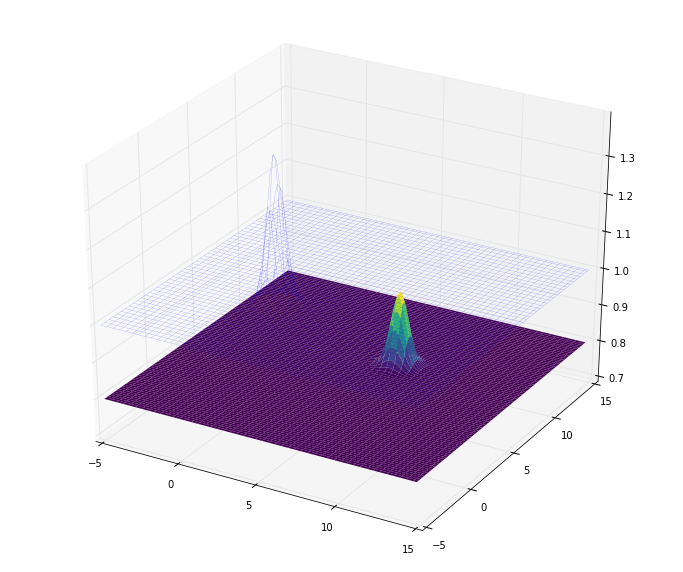

In [109]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(-5,15)
ax.set_ylim(-5,15)
ax.set_zlim(0.7,1.4)

ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

In [117]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    for j in range(nlayers):

        # Jacobians
        def Jx(x,y):
            # do naive c2p for now
            W = np.sqrt((U.U[1, j, x, y, n]**2 * U.gamma_up[0,0] + 
                        2 * U.U[1, j, x, y, n] * U.U[2, j, x, y, n] * U.gamma_up[0,1] + 
                        U.U[2, j, x, y, n]**2 * U.gamma_up[1,1]) / U.U[0, j, x, y, n]**2 + 1)
            ph = U.U[0, j, x, y, n] / W # 
            u = U.U[1, j, x, y, n] / (U.U[0, j, x, y, n] * W) # u_down
            v = U.U[2, j, x, y, n] / (U.U[0, j, x, y, n] * W) # v_down
            
            qx = u * U.gamma_up[0,0] + v * U.gamma_up[0,1] - U.beta[0]/U.alpha
            
            chi = 1 / (1 - u**2 * W**2 - v**2 * W**2)
            
            Jx = np.zeros((3,3))
            
            Jx[0,0] = qx/chi - u
            Jx[0,1] = (1 + v**2*W**2)/W
            Jx[0,2] = -W * u * v
            
            Jx[1,0] = -2*W**3*u*qx*(u**2 + v**2) + 1/W - W*u**2
            Jx[1,1] = qx * (1+W**2*u**2 + W**2*v**2) + u*v**2*W**2
            Jx[1,2] = -v*(1+W**2*u**2)
            
            Jx[2,0] = -W*v*(2*W**2*qx*(u**2+v**2) + u)
            Jx[2,1] = v*(1+v**2*W**2)
            Jx[2,2] = qx*(1+W**2*u**2+W**2*v**2) - W**2*u*v**2
            
            return chi * Jx
        
        def Jy(x,y):
            # do naive c2p for now
            W = np.sqrt((U.U[1, j, x, y, n]**2 * U.gamma_up[0,0] + 
                        2 * U.U[1, j, x, y, n] * U.U[2, j, x, y, n] * U.gamma_up[0,1] + 
                        U.U[2, j, x, y, n]**2 * U.gamma_up[1,1]) / U.U[0, j, x, y, n]**2 + 1)
            ph = U.U[0, j, x, y, n] / W # 
            u = U.U[1, j, x, y, n] / (U.U[0, j, x, y, n] * W) # u_down
            v = U.U[2, j, x, y, n] / (U.U[0, j, x, y, n] * W) # v_down
            
            qy = v * U.gamma_up[1,1] + u * U.gamma_up[0,1] - U.beta[1]/U.alpha
            
            chi = 1 / (1 - u**2 * W**2 - v**2 * W**2)
            
            Jy = np.zeros((3,3))
            
            Jy[0,0] = qy/chi - v
            Jy[0,1] = -W * u * v
            Jy[0,2] = (1 + u**2*W**2)/W
            
            Jy[1,0] = -W*u*(2*W**2*qy*(u**2+v**2) + v) 
            Jy[1,1] = qy*(1+W**2*u**2+W**2*v**2) - W**2*u**2*v 
            Jy[1,2] = u*(1+u**2*W**2) 
            
            Jy[2,0] = -2*W**3*v*qy*(u**2 + v**2) + 1/W - W*v**2
            Jy[2,1] = -u*(1+W**2*v**2)
            Jy[2,2] = qy * (1+W**2*u**2 + W**2*v**2) + u**2*v*W**2
            
            return chi * Jy
        
        A = np.array([[Jx(i,k) for k in range(1,U.ny-1)] for i in range(1,U.nx-1)])
        B = np.array([[Jy(i,k) for k in range(1,U.ny-1)] for i in range(1,U.nx-1)])
        
        A2 = np.array([[np.dot(A[i,k,:,:], A[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])
        B2 = np.array([[np.dot(B[i,k,:,:], B[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])
        AB = np.array([[np.dot(A[i,k,:,:], B[i,k,:,:]) for k in range(U.ny-2)] for i in range(U.nx-2)])        
        
        # to simplify indexing to 3 indices rather than 5
        qn = U.U[:,j,:,:,n]
        
        U.U[:,j,1:-1,1:-1,n+1] = qn[:,1:-1,1:-1] - \
            0.5 * U.dt/U.dx * np.einsum('ijkl,lij->kij', A[:,:,:,:], (qn[:,2:,1:-1] - qn[:,:-2,1:-1])) -\
            0.5 * U.dt/U.dy * np.einsum('ijkl,lij->kij', B[:,:,:,:], (qn[:,1:-1,2:] - qn[:,1:-1,:-2])) +\
            0.5 * (U.dt/U.dx)**2 * np.einsum('ijkl,lij->kij', A2[:,:,:,:], (qn[:,2:,1:-1] - 2*qn[:,1:-1,1:-1] + qn[:,:-2,1:-1])) +\
            0.5 * (U.dt/U.dy)**2 * np.einsum('ijkl,lij->kij', B2[:,:,:,:], (qn[:,1:-1,2:] - 2*qn[:,1:-1,1:-1] + qn[:,1:-1,:-2])) -\
            0.25 * U.dt**2/(U.dx*U.dy) * np.einsum('ijkl,lij->kij', AB[:,:,:,:], (qn[:,2:,2:] - qn[:,2:,:-2] -\
                                                                      qn[:,:-2,2:] + qn[:,:-2,:-2])) 
            
    # do boundaries - periodic
    U.bcs(n+1)   
    """
    U_half = U.U[:,:,:,:,n+1]
    
    for j in range(nlayers):
        
            
        # calculate source terms
        # a more sophisticated scheme for the source terms is needed, but that's a real headache so shall ignore for now
        # and just use operator splitting
        h = U_half[0,:,:,:]
        hu = U_half[1,:,:,:]
        hv = U_half[2,:,:,:] 
        
        sum_hs = np.zeros((U.nx,U.ny))
        sum_qs = 0
        
        if j < (nlayers - 1): # i.e. it has another layer beneath it
            sum_qs += -U.rho[j+1]/U.rho[j] * abs((U.Q[j+1] - U.Q[j]))
            deltaQu = U.rho[j+1]/U.rho[j] * max(0,U.Q[j] - U.Q[j+1]) * (hu[j,:,:] - hu[j+1,:,:]) / h[j,:,:]
            deltaQv = U.rho[j+1]/U.rho[j] * max(0,U.Q[j] - U.Q[j+1]) * (hv[j,:,:] - hv[j+1,:,:]) / h[j,:,:]
        if j > 0: # i.e. has another layer above it
            sum_qs +=  abs(U.Q[j] - U.Q[j-1])
            deltaQu = max(0, U.Q[j] - U.Q[j-1]) * (hu[j,:,:] - hu[j-1,:,:]) / h[j,:,:]
            deltaQv = max(0, U.Q[j] - U.Q[j-1]) * (hv[j,:,:] - hv[j-1,:,:]) / h[j,:,:]
        
        for i in range(j):
            sum_hs += U.rho[i] / U.rho[j] * h[i,:,:]
        for i in range(j+1,nlayers):
            sum_hs += h[i,:,:]
        dx_sumhs = 0.5/U.dx * (sum_hs[2:,1:-1] - sum_hs[:-2,1:-1])
        dy_sumhs = 0.5/U.dy * (sum_hs[1:-1,2:] - sum_hs[1:-1,:-2])
        
        # h
        U.U[0,j,1:-1,1:-1,n+1] += U.dt * (sum_qs)
        
        # hu
        U.U[1,j,1:-1,1:-1,n+1] += U.dt * (-deltaQu[1:-1,1:-1] - U.g * dx_sumhs) * h[j,1:-1,1:-1] + \
            U.dt * U.f * hv[j,1:-1,1:-1]
        
        # hv
        U.U[2,j,1:-1,1:-1,n+1] += U.dt * (-deltaQv[1:-1,1:-1] - U.g * dy_sumhs) * h[j,1:-1,1:-1] - \
            U.dt * U.f * hu[j,1:-1,1:-1]
        
    # do boundaries - periodic
    U.bcs(n+1)
    """

In [118]:
for i in range(nt):
    evolve(i)

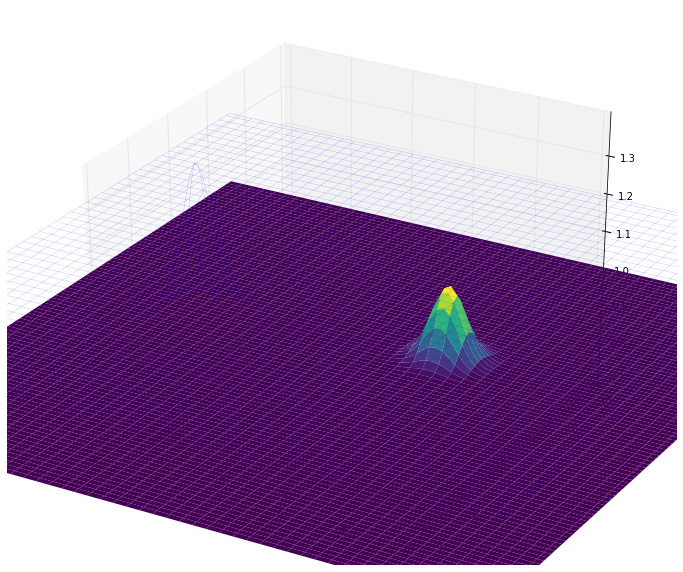

In [119]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0.7,1.4)

n = 1

ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,n], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,n], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

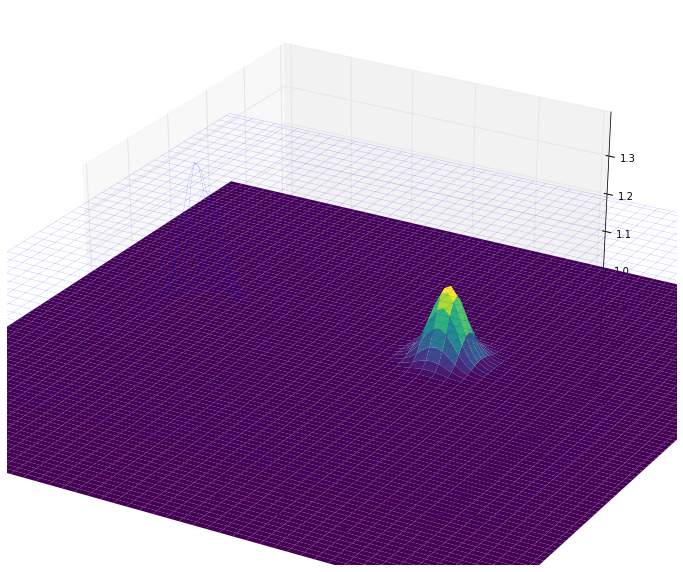

In [120]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
#ax = plt.axes(xlim=(0,10), zlim=(0.7,1.4))
#surface_1 = ax.plot_surface([],[],[], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)[0]

#surface_2 = ax.plot_wireframe([],[],[], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)[0]
#line = ax.plot([],[], lw=2)[0]
#line2 = ax.plot([],[], lw=2)[0]

surface_1 = ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
surface_2 = ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

def init():
    surface_1 = ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    surface_2 = ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)


def animate(i):
    ax.clear()
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X,Y,U.U[0,1,1:-1,1:-1,i], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    ax.plot_wireframe(X,Y,U.U[0,0,1:-1,1:-1,i], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

anim = animation.FuncAnimation(fig, animate, frames=30, interval=200)#, init_func=init)

In [121]:
HTML(anim.to_html5_video())